In [ ]:
from pathlib import Path
import tqdm
from multiprocessing import Pool
from functools import partial

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import db_queries

from spatial_temp_cgf.data_prep.location_mapping import FHS_HIERARCHY_PATH

ROOT = Path('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/zzz_archive/v1')
LABEL = 'tempgrid_o30'


In [ ]:
fhs_loc_meta = pd.read_parquet(FHS_HIERARCHY_PATH).sort_values('sort_order').reset_index(drop=True)

location_ids = fhs_loc_meta.loc[fhs_loc_meta['most_detailed'] == 1, 'location_id'].to_list()
measures = ['stunting', 'wasting']
scenarios = ['ssp119', 'ssp245']
year_ids = list(range(2010, 2023))  # list(range(2010, 2101))


In [ ]:
root = ROOT
label = LABEL
measure = 'stunting'
location_id = 171
scenario = 'ssp119'
year_id = 2010
pd.read_parquet(root / 'results' / label / f'{measure}_{location_id}_{scenario}_{year_id}.parquet')

In [ ]:
def load_prediction(location_id: int, root: Path, label: str, measure: str, scenario: str, year_id: int):
    try:
        data = pd.read_parquet(root / 'results' / label / f'{measure}_{location_id}_{scenario}_{year_id}.parquet').reset_index()
        data['location_id'] = data['fhs_location_id'].astype(int)
        return data.set_index(['location_id', 'year_id', 'age_group_id', 'sex_id', 'scenario', 'measure']).loc[:, 'affected_proportion']
    except FileNotFoundError:
        return pd.Series()

predictions = []
for year_id in tqdm.tqdm(year_ids, total=len(year_ids)):
    for measure in measures:
        for scenario in scenarios:
            load_predictions = partial(
                load_prediction,
                root=ROOT,
                label=LABEL,
                measure=measure,
                scenario=scenario,
                year_id=year_id,
            )
            with Pool(20) as pool:
                location_predictions = list(pool.imap(load_predictions, location_ids))
            predictions += location_predictions
predictions = pd.concat(predictions).sort_index().rename('pred')


In [ ]:
# kwargs = {}
# for id_var in ['location_id', 'year_id', 'age_group_id', 'sex_id']:
#     kwargs[id_var] = predictions.index.get_level_values(id_var).unique().tolist()
# gbd = db_queries.get_outputs(
#     'rei',
#     release_id=9,
#     measure_id=29,
#     metric_id=3,
#     rei_id=[240, 241],
#     **kwargs
# )
# gbd['measure'] = gbd['rei'].str.replace('nutrition_', '')
# gbd = gbd.set_index(['location_id', 'year_id', 'age_group_id', 'sex_id', 'measure']).sort_index().loc[:, 'val'].rename('gbd')

# plot_data = predictions.loc[:, :, :, :, 'ssp119', :].to_frame().join(gbd).dropna()

# plt.scatter(
#     plot_data['gbd'],
#     plot_data['pred'],
#     alpha=0.25
# )
# plt.plot((0, 1), (0, 1), color='red')

In [ ]:
me_ids = db_queries.get_ids('modelable_entity')
me_ids.loc[me_ids['modelable_entity_id'].isin([8949, 8950, 8951, 10556, 10557,
                                               8945, 8946, 8947, 10558, 10559])]


In [ ]:
# me_ids = db_queries.get_ids('modelable_entity')
# me_ids.loc[
#     (me_ids['modelable_entity_name'].str.contains('asting'))
#     & (me_ids['modelable_entity_name'].str.contains('oderate'))
# ]
# me_ids.loc[
#     (me_ids['modelable_entity_name'].str.contains('tunting'))
#     & (me_ids['modelable_entity_name'].str.contains('oderate'))
# ]

# 10557 --> Mild Stunting, < -1 SD (post-ensemble)
# 10559 --> Mild Wasting, < -1 SD (post-ensemble)

# 10556 --> Moderate Stunting, < -2 SD (post-ensemble)
# 10558 --> Moderate Wasting, < -2 SD (post-ensemble)


In [ ]:
age_metadata = db_queries.get_age_metadata(release_id=9)
age_metadata = age_metadata.loc[age_metadata['age_group_days_start'] >= 28]
age_metadata = age_metadata.loc[age_metadata['age_group_years_end'] <= 5]

kwargs = {}
for id_var in ['location_id', 'year_id', 'sex_id']:  # , 'age_group_id'
    kwargs[id_var] = predictions.index.get_level_values(id_var).unique().tolist()

population = db_queries.get_population(
    release_id=9,
    age_group_id=age_metadata['age_group_id'].to_list(),
    **kwargs
)

gbd = []
for measure, me_id in [('stunting', 10556), ('wasting', 10558)]:  # Moderate
# for measure, me_id in [('stunting', 10557), ('wasting', 10559)]:  # Mild
# for measure, me_id in [('stunting', 8949), ('stunting', 8950), ('stunting', 8951),
#                        ('wasting', 8945), ('wasting', 8946), ('wasting', 8947)]:  # Combine individual models
    _gbd = db_queries.get_model_results(
        'epi',
        me_id,
        release_id=9,
        measure_id=5,
        age_group_id=age_metadata['age_group_id'].to_list(),
        **kwargs
    )
    _gbd['measure'] = measure
    gbd.append(_gbd)
gbd = pd.concat(gbd)
gbd = gbd.groupby(['location_id', 'year_id', 'age_group_id', 'sex_id', 'measure'], as_index=False)['mean'].sum()

gbd = gbd.merge(population)
gbd = gbd.merge(age_metadata.loc[:, ['age_group_id', 'age_group_years_start', 'age_group_years_end']])
gbd.loc[gbd['age_group_years_end'] <= 1, 'age_group_id'] = 4
gbd.loc[gbd['age_group_years_start'] >= 1, 'age_group_id'] = 5
gbd['gbd'] = gbd['mean'] * gbd['population']
gbd = gbd.groupby(['location_id', 'year_id', 'age_group_id', 'sex_id', 'measure'])['gbd', 'population'].sum()
gbd['gbd'] /= gbd['population']


In [ ]:
gbd.loc[171, 2010, 4, 1]

In [ ]:
inputs = pd.read_parquet('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/stunting/training_data/2024_06_30.02/data.parquet')
inputs['scenario'] = 'ssp119'
inputs['year_id'] = inputs['int_year']
for int_var in ['location_id', 'year_id', 'age_group_id', 'sex_id']:
    inputs[int_var] = inputs[int_var].astype(int)
inputs = inputs.groupby(['location_id', 'year_id', 'age_group_id', 'sex_id', 'scenario'])[['stunting', 'wasting']].mean()
inputs.columns.name = 'measure'
inputs = inputs.stack().rename('pred')

In [ ]:
# plot_data = predictions.loc[:, :, :, :, 'ssp119', :].to_frame().join(gbd).dropna()
plot_data = inputs.loc[:, :, :, :, 'ssp119', :].to_frame().join(gbd).dropna()
plot_data['pred'] *= plot_data['population']
plot_data['gbd'] *= plot_data['population']
plot_data = plot_data.groupby(['location_id', 'year_id', 'measure'])['pred', 'gbd', 'population'].sum()
plot_data['pred'] /= plot_data['population']
plot_data['gbd'] /= plot_data['population']
plot_data = plot_data.drop('population', axis=1)
plot_data.describe()


In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(11, 8.5))
for measure, color in [('stunting', 'dodgerblue'), ('wasting', 'mediumseagreen')]:
    ax.scatter(
        plot_data.loc[:, :, measure].loc[:, 'gbd'],
        plot_data.loc[:, :, measure].loc[:, 'pred'],
        color=color,
        s=200,
        alpha=0.1
    )
    ax.scatter(
        np.nan,
        np.nan,
        color=color,
        label=measure,
        s=100,
        alpha=1.
    )
    ax.plot((0, 1), (0, 1), color='red')
ax.set_ylabel('Prediction')
ax.set_xlabel('GBD 2021')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.legend()
fig.tight_layout()
fig.show()


In [ ]:
plot_data.loc[555]

In [ ]:
# stunting_grid = stunting_data.groupby('grid_cell').stunting.mean()
# wasting_grid = wasting_data.groupby('grid_cell').stunting.mean()
model.formula

In [ ]:
pd.concat([stunting_grid, wasting_grid.rename('wasting')], axis=1).dropna()

In [ ]:

import pickle

def load_model_data(root: Path, label: str, measure: str, age_group_id: int, sex_id: int):
    with open(root / 'models' / label / f'model_{measure}_{age_group_id}_{sex_id}.pkl', 'rb') as file:
        model = pickle.load(file)
    data = model.data
    data['age_group_id'] = age_group_id
    data['sex_id'] = sex_id
    data['measure'] = measure
    data = data.rename(columns={measure: 'obs'})
    return data.groupby(['ihme_loc_id', 'age_group_id', 'sex_id', 'measure'])[['obs', 'fits']].mean()


In [ ]:
new = pd.read_parquet('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/stunting/training_data/2024_06_30.02/data.parquet')
for int_var in ['age_group_id', 'sex_id']:
    new[int_var] = new[int_var].astype(int)
new = new.groupby(['ihme_loc_id', 'age_group_id', 'sex_id'])[['stunting', 'wasting']].mean()
new.columns.name = 'measure'
new = new.stack().rename('pred')

old = []
for age_group_id in [4, 5]:
    for sex_id in [1, 2]:
        old.append(load_model_data(ROOT, LABEL, 'stunting', age_group_id, sex_id))
old = pd.concat(old).sort_index()
old

In [ ]:
old.loc['ZWE']

In [ ]:
foo = pd.concat([
    new.rename('new'),
    old.rename('old')
], axis=1).loc[:, :, :, 'stunting']
plt.scatter(
    foo['new'],
    foo['old'],
)
plt.xlabel('From dataset')
plt.ylabel('From model object')
plt.show()

In [ ]:
foo.loc['ZWE']

In [ ]:
predictions.loc[198, :, :, :, 'ssp119', 'stunting'].groupby(['age_group_id', 'sex_id']).mean()

In [ ]:
root=ROOT
label=LABEL
measure='stunting'
age_group_id=5
sex_id=1
with open(root / 'models' / label / f'model_{measure}_{age_group_id}_{sex_id}.pkl', 'rb') as file:
    model = pickle.load(file)
md = model.data
md = md.loc[md['ihme_loc_id'] == 'ZWE']
md = md.groupby('grid_cell')[['stunting', 'fits']].mean()
plt.scatter(md['stunting'], md['fits'])
plt.xlabel('obs')
plt.ylabel('pred')
plt.plot((0, 1), (0, 1), color='red')
plt.show()


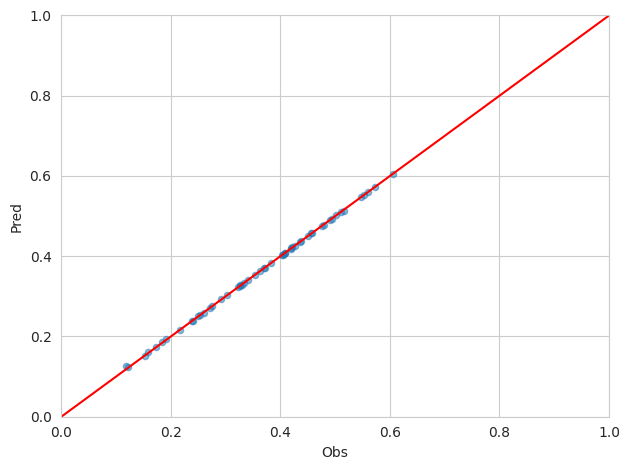

In [9]:
# import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# measure = 'stunting'

plot_data = []
models = {}
for age_group_id in [4, 5]:
    for sex_id in [1, 2]:
        with open(f'/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/{measure}/models/2024_07_01.15/{age_group_id}_{sex_id}.pkl', 'rb') as file:
            model = pickle.load(file)
        data = model.data
        data['measure'] = measure
        data = data.rename(columns={measure: 'obs'})
        data = data.groupby(['ihme_loc_id', 'age_group_id', 'sex_id', 'measure'])[['obs', 'fits']].mean()
        plot_data.append(data)
        models[f'{age_group_id}_{sex_id}'] = model
plot_data = pd.concat(plot_data)

plt.scatter(
    data['obs'],
    data['fits'],
    s=20,
    alpha=0.5
)
plt.plot(
    (0, 1),
    (0, 1),
    color='red'
)
plt.xlim(0, 1)
plt.xlabel('Obs')
plt.ylim(0, 1)
plt.ylabel('Pred')
plt.tight_layout()
plt.show()


In [11]:
dir(models['5_1'])

['AIC',
 'BIC',
 '_REML',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_conf_int',
 '_get_ngrps',
 '_make_factors',
 '_permute',
 '_refit_orthogonal',
 '_set_R_stdout',
 '_verify_preds',
 'anova',
 'coefs',
 'confint',
 'contrast_codes',
 'contrasts',
 'data',
 'design_matrix',
 'factors',
 'factors_prev_',
 'family',
 'fit',
 'fits',
 'fitted',
 'fixef',
 'formula',
 'grps',
 'logLike',
 'marginal_contrasts',
 'marginal_estimates',
 'model_obj',
 'plot',
 'plot_summary',
 'post_hoc',
 'predict',
 'ranef',
 'ranef_corr',
 'ranef_var',
 'ranked_data',
 'raw_data',
 'residuals',
 'sig_type',
 'simulate',
 'summary',
 'var_info',
 'warnings']

In [27]:
coefs = []
for label, model in models.items():
    coefs.append(models[label].coefs['Estimate'].rename(label))
pd.concat(coefs, axis=1)

,4_1,4_2,5_1,5_2
(Intercept),-0.139447,-0.763349,1.216418,1.020429
days_over_30C,0.463517,0.615742,0.768482,0.805035
ldi_pc_pd,-3.774639,-3.607931,-10.721134,-11.570389
elevation,-0.089166,0.060132,-0.264742,-0.191128
mean_temperature,-1.341182,-1.141788,-1.492090,-1.530973
any_days_over_30C,0.069989,0.090890,0.030200,0.044970
ldi_pc_pd:any_days_over_30C,1.615681,0.670859,3.960988,4.325797


In [24]:
models['5_2'].var_info['ldi_pc_pd']['transformer']

In [26]:
models['5_2'].data.describe()

,intercept,days_over_30C,ldi_pc_pd,elevation,mean_temperature,any_days_over_30C,stunting,residuals,fits,age_group_id,sex_id
count,373766.0,373766.000000,3.737660e+05,373766.000000,373766.000000,373766.000000,373766.000000,373766.000000,373766.000000,373766.0,373766.0
mean,1.0,0.124044,4.146039e-02,0.856104,0.808541,0.538773,0.380711,-0.068277,0.380711,5.0,2.0
std,0.0,0.173502,6.271199e-02,0.070107,0.117423,0.498495,0.485562,1.116545,0.128365,0.0,0.0
min,1.0,0.000000,1.861596e-07,0.000000,0.000000,0.000000,0.000000,-1.679422,0.000009,5.0,2.0
25%,1.0,0.000000,1.119366e-02,0.848545,0.759210,0.000000,0.000000,-1.028994,0.295205,5.0,2.0
50%,1.0,0.011111,2.502893e-02,0.854308,0.844691,1.000000,0.000000,-0.716582,0.410506,5.0,2.0
75%,1.0,0.237037,4.639745e-02,0.867461,0.884180,1.000000,1.000000,1.223161,0.470288,5.0,2.0
max,1.0,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,4.724173,0.755913,5.0,2.0


In [29]:
pd.read_parquet('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/stunting/results/2024_07_02.01/2020_ssp119.parquet').describe()

,location_id,age_group_id,sex_id,value
count,4188.000000,4188.00000,4188.00000,4.188000e+03
mean,25953.134670,4.50000,1.50000,8.428733e-04
std,21402.105079,0.50006,0.50006,5.231846e-03
min,6.000000,4.00000,1.00000,0.000000e+00
25%,536.000000,4.00000,1.00000,0.000000e+00
50%,35494.000000,4.50000,1.50000,6.757759e-15
75%,44773.000000,5.00000,2.00000,6.442286e-06
max,60137.000000,5.00000,2.00000,1.262279e-01
